# Creating a Custom 5×5 Maze

In [1]:
import numpy as np
import gym
from gym import spaces
import random

class MazeEnv(gym.Env):
    def __init__(self):
        super(MazeEnv, self).__init__()

        # Maze: 0 = empty, 1 = wall, 2 = goal
        self.maze = np.array([
            [0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 0, 0, 1, 0],
            [1, 0, 1, 0, 0],
            [0, 0, 0, 1, 2]
        ])
        self.start_pos = (0, 0)
        self.agent_pos = self.start_pos

        # 4 possible actions: up, down, left, right
        self.action_space = spaces.Discrete(4)

        # Observation space: position (x, y)
        self.observation_space = spaces.Box(low=0, high=4, shape=(2,), dtype=np.int32)

    def reset(self):
        self.agent_pos = self.start_pos
        return np.array(self.agent_pos, dtype=np.int32)

    def step(self, action):
        x, y = self.agent_pos

        if action == 0 and x > 0: x -= 1  # Up
        elif action == 1 and x < 4: x += 1  # Down
        elif action == 2 and y > 0: y -= 1  # Left
        elif action == 3 and y < 4: y += 1  # Right

        # Check if wall
        if self.maze[x, y] == 1:
            x, y = self.agent_pos  # stay in place

        self.agent_pos = (x, y)
        done = self.maze[x, y] == 2
        reward = 1 if done else -0.1  # encourage faster path

        return np.array(self.agent_pos, dtype=np.int32), reward, done, {}

    def render(self):
        grid = np.copy(self.maze)
        x, y = self.agent_pos
        grid[x, y] = 9  # Agent represented by 9
        print(grid)


# Defining the Agent’s Start and Goal Positions

In [2]:
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt


# Implementing Gym-style Custom Environment

In [3]:
def build_model(input_shape, action_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(action_size, activation='linear')  # Q-values for each action
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model


In [4]:
class ReplayBuffer:
    def __init__(self, max_size=2000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


In [5]:
env = MazeEnv()
state_shape = (2,)  # (x, y)
action_size = env.action_space.n

model = build_model(state_shape, action_size)
target_model = build_model(state_shape, action_size)
target_model.set_weights(model.get_weights())  # sync weights initially

buffer = ReplayBuffer()


In [6]:
def get_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)  # explore
    q_values = model.predict(state[np.newaxis], verbose=0)
    return np.argmax(q_values[0])  # exploit


In [9]:
def train_from_replay(batch_size, gamma):
    if buffer.size() < batch_size:
        return

    minibatch = buffer.sample(batch_size)

    states = np.array([x[0] for x in minibatch])
    actions = np.array([x[1] for x in minibatch])
    rewards = np.array([x[2] for x in minibatch])
    next_states = np.array([x[3] for x in minibatch])
    dones = np.array([x[4] for x in minibatch])

    q_values = model.predict(states, verbose=0)
    q_next = target_model.predict(next_states, verbose=0)

    for i in range(batch_size):
        q_values[i][actions[i]] = rewards[i]
        if not dones[i]:
            q_values[i][actions[i]] += gamma * np.max(q_next[i])

    model.fit(states, q_values, epochs=1, verbose=0)


In [10]:
episodes = 200
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
target_update_freq = 10
reward_history = []
max_steps = 100  # عدد الخطوات الأقصى داخل كل حلقة

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    step = 0  # عدد الخطوات

    while not done and step < max_steps:
        action = get_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        train_from_replay(batch_size, gamma)
        step += 1  # زيادة الخطوة

    reward_history.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if ep % target_update_freq == 0:
        target_model.set_weights(model.get_weights())

    print(f"Episode {ep+1}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")


Episode 1, Reward: -10.00, Epsilon: 0.995
Episode 2, Reward: -10.00, Epsilon: 0.990
Episode 3, Reward: -10.00, Epsilon: 0.985
Episode 4, Reward: -10.00, Epsilon: 0.980
Episode 5, Reward: -10.00, Epsilon: 0.975
Episode 6, Reward: -10.00, Epsilon: 0.970
Episode 7, Reward: -10.00, Epsilon: 0.966
Episode 8, Reward: -10.00, Epsilon: 0.961
Episode 9, Reward: -10.00, Epsilon: 0.956
Episode 10, Reward: -10.00, Epsilon: 0.951
Episode 11, Reward: -10.00, Epsilon: 0.946
Episode 12, Reward: -10.00, Epsilon: 0.942
Episode 13, Reward: -10.00, Epsilon: 0.937
Episode 14, Reward: -10.00, Epsilon: 0.932
Episode 15, Reward: -10.00, Epsilon: 0.928
Episode 16, Reward: -10.00, Epsilon: 0.923
Episode 17, Reward: -10.00, Epsilon: 0.918
Episode 18, Reward: -10.00, Epsilon: 0.914
Episode 19, Reward: -10.00, Epsilon: 0.909
Episode 20, Reward: -10.00, Epsilon: 0.905
Episode 21, Reward: -10.00, Epsilon: 0.900
Episode 22, Reward: -10.00, Epsilon: 0.896
Episode 23, Reward: -10.00, Epsilon: 0.891
Episode 24, Reward: 

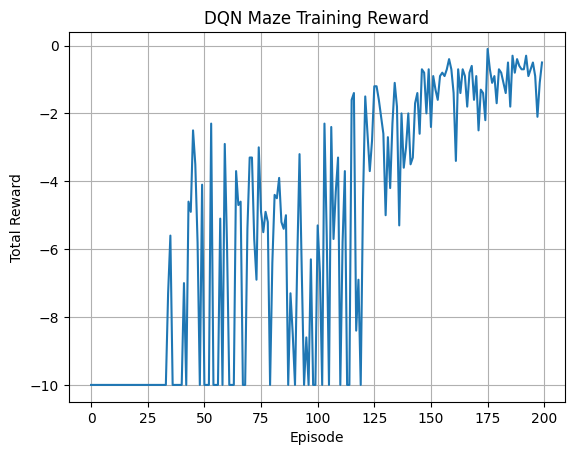

In [11]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Maze Training Reward")
plt.grid(True)
plt.show()


In [12]:
import time

def test_agent(env, model, max_steps=50, delay=0.5):
    state = env.reset()
    done = False
    step = 0
    total_reward = 0

    print("Initial Maze:")
    env.render()
    print()

    while not done and step < max_steps:
        # Predict the best action
        q_values = model.predict(state[np.newaxis], verbose=0)
        action = np.argmax(q_values[0])

        # Take the action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
        step += 1

        print(f"Step {step}, Action: {action}, Reward: {reward:.2f}")
        env.render()
        print()
        time.sleep(delay)

    print(f"✅ Total Reward: {total_reward:.2f} in {step} steps")


In [13]:
test_agent(env, model)


Initial Maze:
[[9 1 0 0 0]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 1, Action: 1, Reward: -0.10
[[0 1 0 0 0]
 [9 1 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 2, Action: 1, Reward: -0.10
[[0 1 0 0 0]
 [0 1 0 1 0]
 [9 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 3, Action: 3, Reward: -0.10
[[0 1 0 0 0]
 [0 1 0 1 0]
 [0 9 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 4, Action: 3, Reward: -0.10
[[0 1 0 0 0]
 [0 1 0 1 0]
 [0 0 9 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 5, Action: 0, Reward: -0.10
[[0 1 0 0 0]
 [0 1 9 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 6, Action: 0, Reward: -0.10
[[0 1 9 0 0]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 7, Action: 3, Reward: -0.10
[[0 1 0 9 0]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 8, Action: 3, Reward: -0.10
[[0 1 0 0 9]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 9, Action: 1, Reward: -0.10
[[0 1 0 0 0]
 [0 1 0 1 9]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 0 1 2]]

Step 10, Action: 1,

In [14]:
action_map = {0: "↑", 1: "↓", 2: "←", 3: "→"}
print("Action:", action_map[action])


Action: ↓


In [16]:
def test_agent_with_path(env, model, max_steps=50):
    state = env.reset()
    done = False
    step = 0
    path = [tuple(state)]  # لتخزين المسار

    while not done and step < max_steps:
        q_values = model.predict(state[np.newaxis], verbose=0)
        action = np.argmax(q_values[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        path.append(tuple(state))
        step += 1

    # رسم الخريطة النهائية
    final_map = np.copy(env.maze).astype(str)

    for x in range(5):
        for y in range(5):
            if final_map[x, y] == '1':
                final_map[x, y] = 'W'  # Wall
            elif final_map[x, y] == '2':
                final_map[x, y] = 'G'  # Goal
            else:
                final_map[x, y] = ' '  # Empty

    for pos in path:
        x, y = pos
        if final_map[x, y] not in ['G', 'W']:
            final_map[x, y] = '.'

    # تمييز نقطة البداية والنهاية
    sx, sy = path[0]
    ex, ey = path[-1]
    final_map[sx, sy] = 'S'
    if final_map[ex, ey] != 'G':
        final_map[ex, ey] = 'E'  # End if not goal

    print("🔍 Final Path Map:")
    for row in final_map:
        print(" ".join(row))


In [17]:
test_agent_with_path(env, model)


🔍 Final Path Map:
S W . . .
. W . W .
. . . W .
W   W   .
      W G


In [18]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [21]:
def animate_agent_path(env, model, max_steps=50):
    state = env.reset()
    done = False
    step = 0
    path = [tuple(state)]

    while not done and step < max_steps:
        q_values = model.predict(state[np.newaxis], verbose=0)
        action = np.argmax(q_values[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        path.append(tuple(state))
        step += 1

    maze = env.maze
    grid_size = maze.shape[0]

    fig, ax = plt.subplots(figsize=(5, 5))

    def update(frame):
        ax.clear()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_title(f"Step {frame+1}")
        for x in range(grid_size):
            for y in range(grid_size):
                val = maze[x, y]
                if val == 1:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, color="black"))
                elif val == 2:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, color="green"))
                else:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, edgecolor="gray", fill=False))

        # Agent
        x, y = path[frame]
        ax.add_patch(plt.Circle((y + 0.5, grid_size - 1 - x + 0.5), 0.3, color="blue"))

        # Start
        sx, sy = path[0]
        ax.add_patch(plt.Circle((sy + 0.5, grid_size - 1 - sx + 0.5), 0.1, color="red"))

    ani = animation.FuncAnimation(fig, update, frames=len(path), interval=700)
    return ani


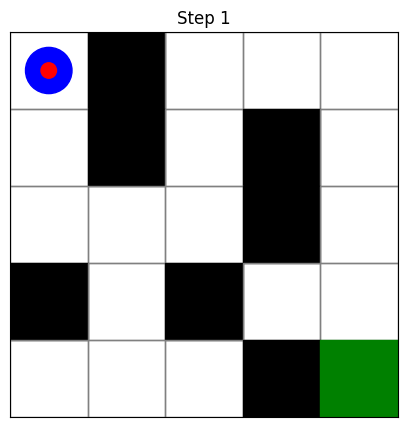

In [22]:
from IPython.display import HTML
ani = animate_agent_path(env, model)
HTML(ani.to_jshtml())


In [23]:
def animate_agent_path_video(env, model, max_steps=50):
    state = env.reset()
    done = False
    step = 0
    path = [tuple(state)]

    while not done and step < max_steps:
        q_values = model.predict(state[np.newaxis], verbose=0)
        action = np.argmax(q_values[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        path.append(tuple(state))
        step += 1

    maze = env.maze
    grid_size = maze.shape[0]

    fig, ax = plt.subplots(figsize=(5, 5))

    def update(frame):
        ax.clear()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_title(f"Step {frame+1}")
        for x in range(grid_size):
            for y in range(grid_size):
                val = maze[x, y]
                if val == 1:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, color="black"))
                elif val == 2:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, color="green"))
                else:
                    ax.add_patch(plt.Rectangle((y, grid_size - 1 - x), 1, 1, edgecolor="gray", fill=False))

        # Agent
        x, y = path[frame]
        ax.add_patch(plt.Circle((y + 0.5, grid_size - 1 - x + 0.5), 0.3, color="blue"))

        # Start
        sx, sy = path[0]
        ax.add_patch(plt.Circle((sy + 0.5, grid_size - 1 - sx + 0.5), 0.1, color="red"))

    ani = animation.FuncAnimation(fig, update, frames=len(path), interval=700)
    return ani


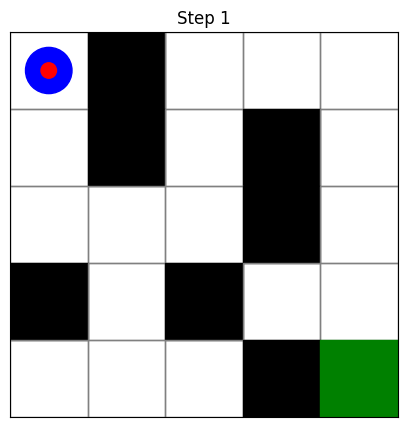

In [24]:
ani = animate_agent_path_video(env, model)
HTML(ani.to_html5_video())
